# Data Inspection

## Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pycountry

## Load Data

In [4]:
country_df = pd.read_pickle("../../data/generated/country_df.pkl")
comes_from_df = pd.read_pickle("../../data/generated/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/generated/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/generated/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/generated/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/generated/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/generated/character_df.pkl")
actor_df = pd.read_pickle("../../data/generated/actor_df.pkl")
movie_df = pd.read_pickle("../../data/generated/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/generated/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/generated/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/generated/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")

## Helpers

In [5]:
COUNTRY_MAPPING = {"west germany": "germany", "weimar republic": "germany",
"german democratic republic": "germany",
"nazi germany": "germany", "german language": "germany",
"soviet union": "russia", "soviet occupation zone": "russia",
"socialist federal republic of yugoslavia": "yugoslavia", 
"federal republic of yugoslavia" : "yugoslavia",
"uzbek ssr" : "uzbekistan",
"georgian ssr": "georgia",
"kingdom of great britain": "united kingdom", "northern ireland": "united kingdom",
"wales": "united kingdom", "england": "united kingdom", "scotland": "united kingdom",
"serbia and montenegro" : "serbia and montenegro",
"kingdom of italy": "italy",
"mandatory palestine": "palestinian territories",
"ukranian ssr": "ukraine", "ukrainian ssr": "ukraine",
"malayalam language": "india",
"slovak republic" : "slovakia", "republic of china": "china"}

In [6]:
CUSTOM_ALPHA3_CODE_MAPPING = {"bolivia":"BOL","burma":"BUR",
"czech republic":"CZE","czechoslovakia":"CSK",
"democratic republic of the congo":"COD","england":"GBR",
"federal republic of yugoslavia":"YUG","georgian ssr": "GEO",
"german democratic republic":"DEU","german":"DEU",
"iran":"IRN","kingdom of great britain":"GBR",
"kingdom of italy":"ITA","korea":"KOR",
"macau":"MAC","mandatory palestine":"PSE",
"nazi germany":"DEU","northern ireland":"GBR",
"palestinian territories":"PSE","republic of china":"CHN",
"republic of macedonia":"MKD","russia":"RUS",
"scotland":"GBR","serbia and montenegro":"SCG",
"slovak republic":"SVK","socialist federal republic of yugoslavia":"YUG",
"south korea":"KOR","soviet occupation zone":"RUS",
"soviet union":"RUS","taiwan":"TWN",
"ukrainian ssr":"UKR","ukranian ssr":"UKR",
"united states of america":"USA","uzbek ssr":"UZB",
"venezuela":"VEN","vietnam":"VNM",
"wales":"GBR","weimar republic":"DEU",
"west germany":"DEU","yugoslavia":"YUG",
"german language":"DEU"}

In [7]:
def alpha3code(country:str)->str:
    """
    Get the ISO_3166-1 alpha-3 code for the given country.
    
    :param country: Country name.
    
    :return: Three letters alpha-3 code, or "None" if not available.
    """
    CODE = "None"
    try:
        CODE = pycountry.countries.get(name=country).alpha_3
    except:
        if country in CUSTOM_ALPHA3_CODE_MAPPING.keys():
            CODE = CUSTOM_ALPHA3_CODE_MAPPING[country]
    return CODE

In [8]:
def movie_count_bar_plot(movie_count_df: pd.DataFrame,title: str,is_log=False):
    """
    Plot the movie count per entry in the given dataframe.
    
    :param movie_count_df: Pandas dataframe with one column for the movie count
                           and the entry name as index.
    :param title: Title of the plot.
    :param is_log: Boolean indicating if the count is in log scale.
    
    """
    plot_height = np.ceil(len(movie_count_df)/5)
    fig, ax = plt.subplots(1,figsize=(10,plot_height))
    ax.set_title(title)
    sns.barplot(x=movie_count_df.movie_count,y=movie_count_df.index,
                orient="h",ax=ax, color="grey")
    if is_log:
        ax.set_xlabel("Movie number in log scale");
    else:
        ax.set_xlabel("Movie number");

In [9]:
def count_box_plot(count_df: pd.DataFrame, title: str):
    """
    Plot the movie count distribution in a box plot.
    
    :param count_df: Pandas dataframe with one column for the entry count
                           and the entry name as index.
    :param title: Title of the plot.
    :param is_log: Boolean indicating if the count is in log scale.
    
    """
    fig,axs = plt.subplots(1,2,figsize=(6,6))
    fig.suptitle(title)
    sns.boxplot(count_df,ax=axs[0])
    axs[0].set_title("With outliers")
    sns.boxplot(count_df,showfliers=False,ax=axs[1])
    axs[1].set_title("Without outliers");

In [29]:
def count_draw_histogram(count_df: pd.DataFrame, log_count_df: pd.DataFrame,
                         title: str, log_ax="x"):
    """
    Plot the histogram of the movie counts in normal and log scale.
    
    :param count_df: Pandas dataframe with one column for the entry count
                           and the entry name as index.
    :param count_df: Pandas dataframe with one column for the entry count
                           in log scale and the entry name as index.
    :param title: Title of the plot.
    :param log_ax: Axis on which to perform the log transformation (default x).
    
    """
    fig,axs = plt.subplots(1,2,figsize=(12,6))
    fig.suptitle(title)
    count_quantity = count_df.index.name.split("_")[0]    
    # Regular histogram
    sns.histplot(count_df,ax=axs[0])
    axs[0].set_title("Regular Scale")
    axs[0].set_xlabel(f"{count_df.columns[0]}")
    axs[0].set_ylabel(f"Count of {count_quantity}")
    # Log histogram (log on x or y axis)
    axs[1].set_title("Log Scale")
    if log_ax == "x":
        sns.histplot(log_count_df,ax=axs[1])
        axs[1].set_xlabel(f"Log({count_df.columns[0]})")
        axs[1].set_ylabel(f"Count of {count_quantity}")
    elif log_ax == "y":
        sns.histplot(count_df,ax=axs[1])
        axs[1].set_yscale("log")
        axs[1].set_ylabel(f"Log(Count of {count_quantity})")
        axs[1].set_xlabel(f"{count_df.columns[0]}")
    else:
        raise ValueError("Please the log_ax value should be either x or y.")

In [238]:
def get_top_and_bot_of_series(series:pd.Series, movie_dataframe: pd.DataFrame, elem_nb=10):
    """
    Print the top and bottom elements of the given series.
    
    :param series: Pandas series from which to draw items.
    :param movie_dataframe: Pandas dataframe from which we can retrive movie names.
    :elem_nb: Number of elements to print for the top and bot elements.
    
    """
    sorted_series = series.sort_values(key=lambda l:-l)
    top_items = sorted_series.head(elem_nb).reset_index()
    top_items["movie_name"] = top_items["movie_id"].apply(lambda i: movie_dataframe.loc[i,"name"])
    top_items = top_items.set_index("movie_name").drop("movie_id",axis=1)
    print(f"The {elem_nb} movies with the highest {series.name} are:\n")
    print(top_items.to_markdown())
    bot_items = sorted_series.tail(elem_nb).reset_index()
    bot_items["movie_name"] = bot_items["movie_id"].apply(lambda i: movie_dataframe.loc[i,"name"])
    bot_items = bot_items.set_index("movie_name").drop("movie_id",axis=1)
    print(f"\nThe {elem_nb} movies with the lowest {series.name} are:\n")
    print(bot_items.to_markdown())

## Country

In this section we will study the data distribution of the countries in our dataset. Indeed, there are many countries that are widely represented such as USA or India, and others that produced only a few movies accross the year (at least in the CMU dataset).

#### Country Aggregation

Some countries are duplicated because for example of different time scales (e.g. nazi germany, west germany, recent germany). Then we have to aggregate them together.

In [11]:
serbia_and_montenegro_ids = comes_from_df[
    comes_from_df["country_name"] == "serbia and montenegro"]["movie_id"].to_list()
comes_from_df = comes_from_df[comes_from_df["country_name"] != "serbia and montenegro"]
new_serbia_entries = pd.DataFrame(
    zip(serbia_and_montenegro_ids,["serbia"]*len(serbia_and_montenegro_ids)),
    columns=["movie_id","country_name"])
new_montenegro_entries = pd.DataFrame(
    zip(serbia_and_montenegro_ids,["montenegro"]*len(serbia_and_montenegro_ids)),
    columns=["movie_id","country_name"])
comes_from_df = pd.concat([comes_from_df,new_serbia_entries,new_montenegro_entries]).drop_duplicates()

In [12]:
comes_from_df["country_name"] = comes_from_df["country_name"].apply(lambda c: COUNTRY_MAPPING[c] if c in COUNTRY_MAPPING.keys() else c)

### Descriptive statistics
From the following plots we can see that our data is heavy tailed, with a lot of countries having only a few movies. We will thus need to use robust statistics.

In [13]:
country_count_df = comes_from_df.groupby("country_name").count().sort_values("movie_id",key=lambda l: -l)
country_count_df.columns = ["movie_count"]
country_log_count_df = country_count_df.apply(np.log)

In [14]:
country_count_median = country_count_df.median().item()
print(f"The median number of movies per country is {country_count_median}.")

The median number of movies per country is 42.5.


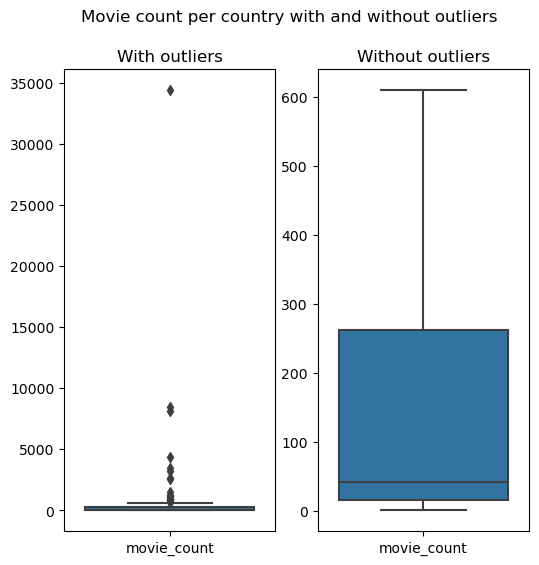

In [15]:
count_box_plot(country_count_df,"Movie count per country with and without outliers")

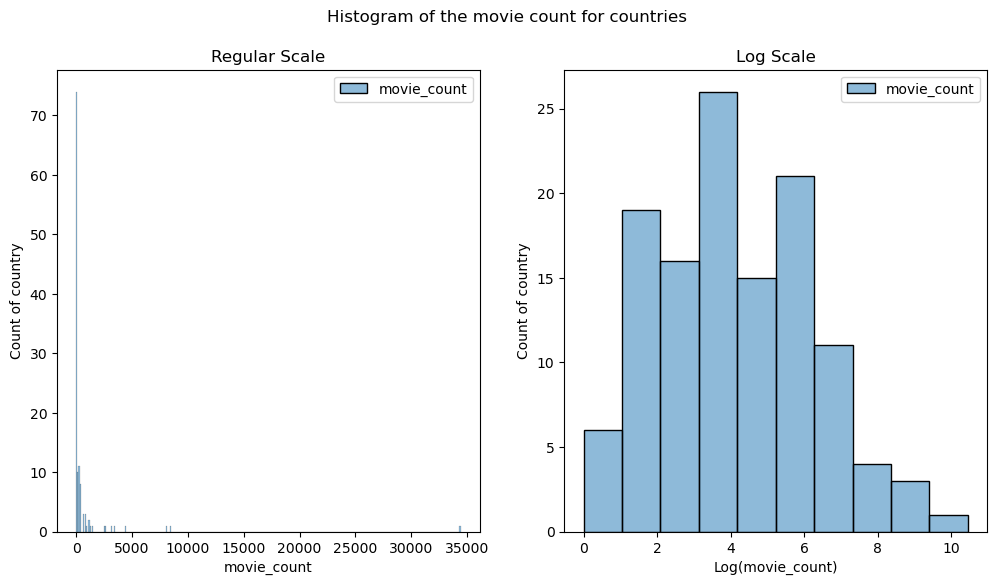

In [30]:
count_draw_histogram(country_count_df,country_log_count_df,
                           "Histogram of the movie count for countries")

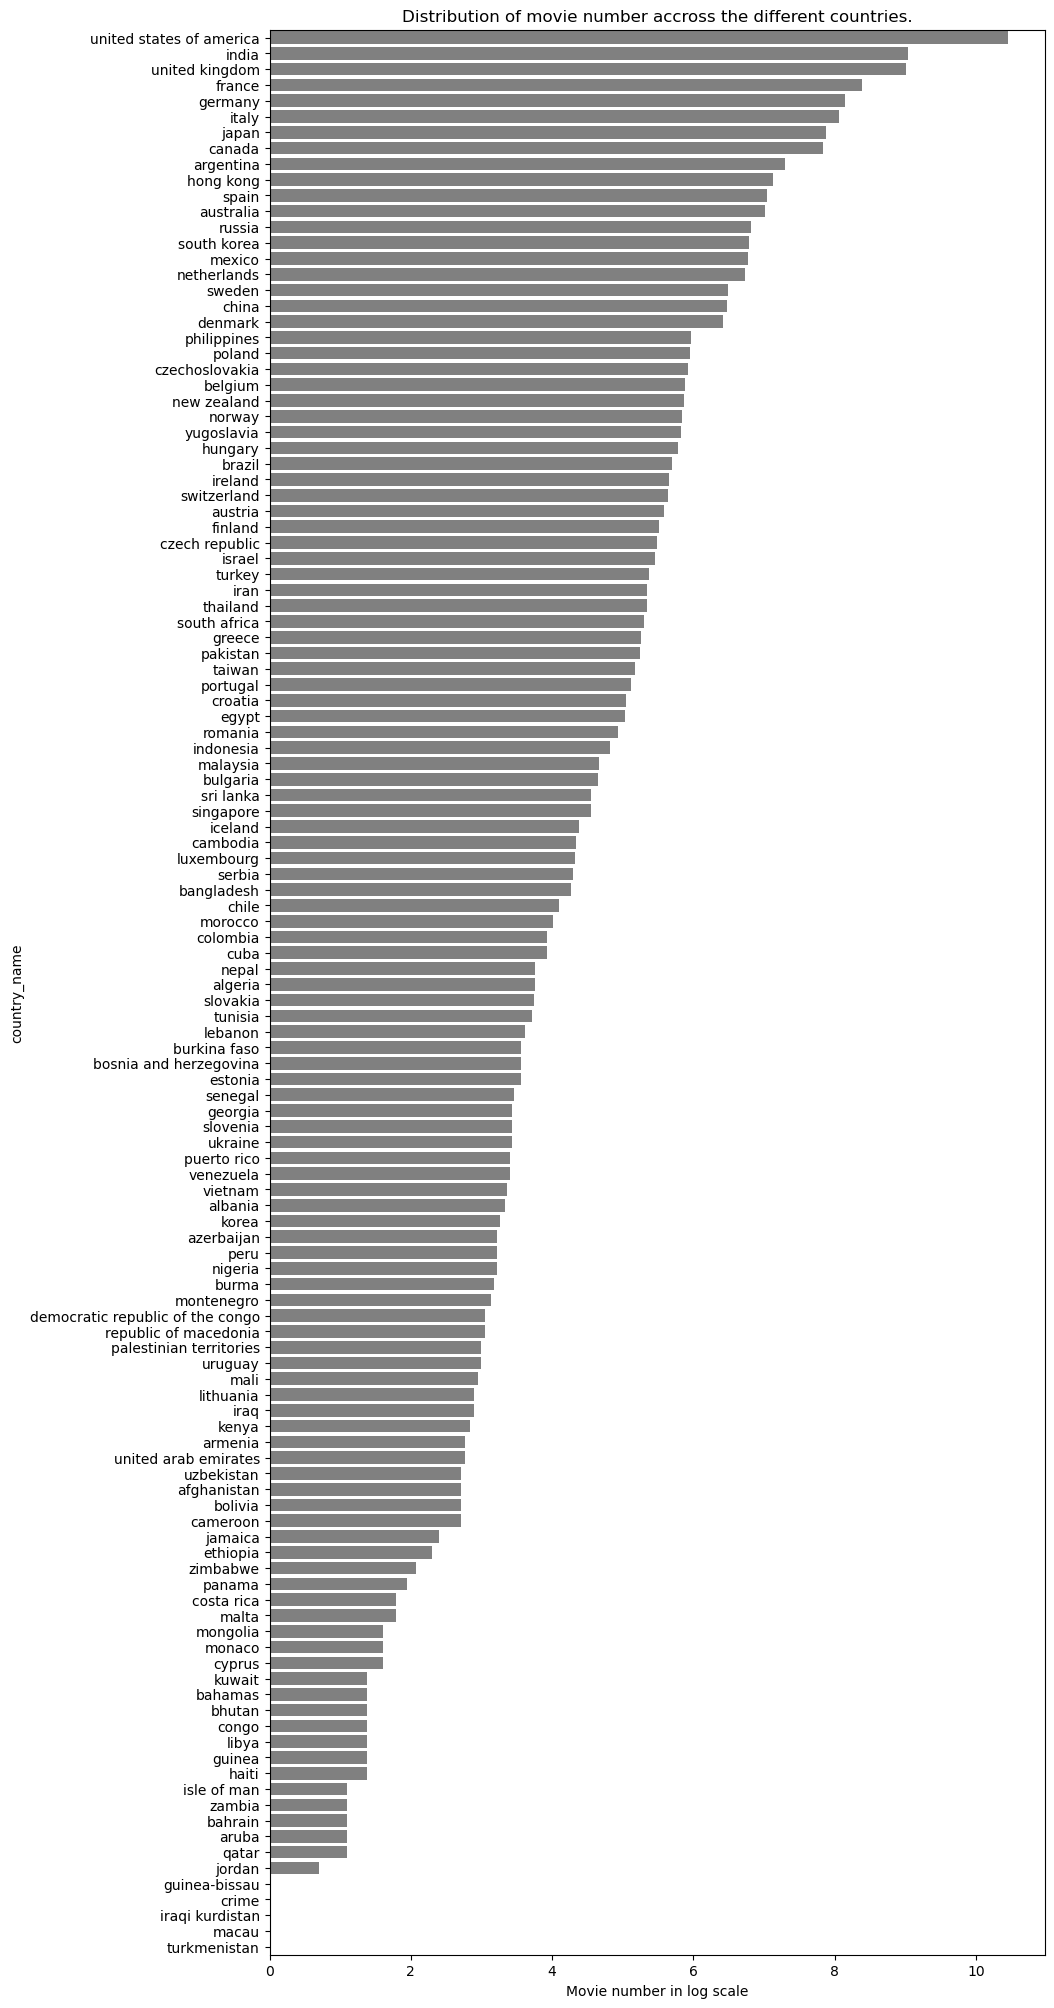

In [17]:
movie_count_bar_plot(country_log_count_df,"Distribution of movie number accross the different countries.",
                    is_log=True)

### Top and bottom countries

In [18]:
print("The top 10 countries are:\n")
print(country_count_df.head(10).to_markdown())
print("\nThe bottom 10 countries are:\n")
print(country_count_df.tail(10).to_markdown())

The top 10 countries are:

| country_name             |   movie_count |
|:-------------------------|--------------:|
| united states of america |         34408 |
| india                    |          8413 |
| united kingdom           |          8153 |
| france                   |          4395 |
| germany                  |          3454 |
| italy                    |          3168 |
| japan                    |          2647 |
| canada                   |          2534 |
| argentina                |          1468 |
| hong kong                |          1240 |

The bottom 10 countries are:

| country_name    |   movie_count |
|:----------------|--------------:|
| zambia          |             3 |
| bahrain         |             3 |
| aruba           |             3 |
| qatar           |             3 |
| jordan          |             2 |
| guinea-bissau   |             1 |
| crime           |             1 |
| iraqi kurdistan |             1 |
| macau           |             1 |
| turk

### World Map 
To have a better visualization of the movie repartition accross the globe, we will plot the logarithm of the movie count for each country available in our dataset. Note that for some countries such as yugoslavia we decided to not keep trace of them in this plot as they have been splitted in several different countries and the paternity of the movie is hard to decide.

In [60]:
country_code_log_count_df = country_log_count_df.reset_index()
country_code_log_count_df["CODE"] = country_code_log_count_df["country_name"].apply(alpha3code)
country_code_log_count_df = country_code_log_count_df.set_index("country_name")

In [61]:
world_countries_df = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
world_countries_df.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world_wrong_code_ids = world_countries_df["CODE"] == "-99"
world_wrong_code = world_countries_df[world_wrong_code_ids]
world_countries_df.loc[world_wrong_code_ids,"CODE"] = world_wrong_code["name"].apply(alpha3code)
world_merge = world_countries_df.merge(country_code_log_count_df,on='CODE')
world_merge = world_merge[~(world_merge["CODE"] == "None")]

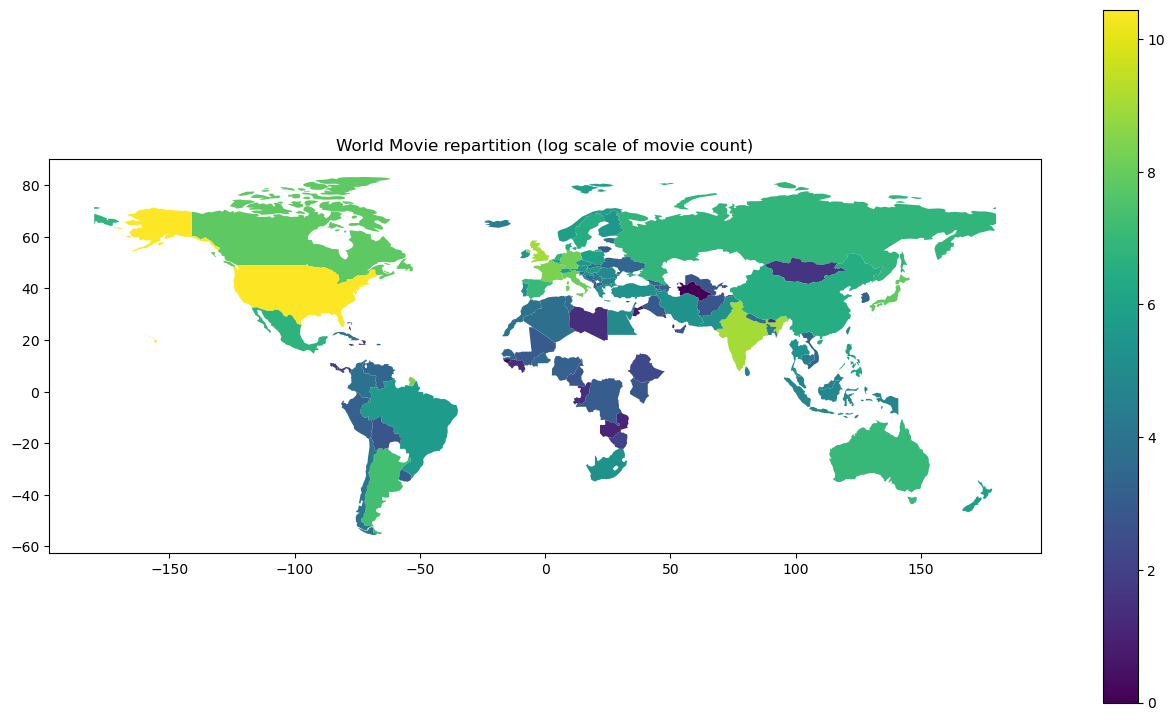

In [62]:
fig,ax = plt.subplots(1,figsize=(16,9))
ax.set_title("World Movie repartition (log scale of movie count)")
world_merge.plot(column="movie_count",legend=True,ax=ax);

## Movie to Country Relation
We now focus on the links between movies and countries. More especially, we are interested in the distribution of countries per movie.

In [63]:
country_per_movie_count_df = comes_from_df.groupby("movie_id").count().sort_values("country_name",key=lambda l: -l)
country_per_movie_count_df.columns = ["country_count"]
country_per_movie_log_count_df = country_per_movie_count_df.apply(np.log)

In [64]:
country_per_movie_count_median = country_per_movie_count_df.median().item()
print(f"The median number of countries per movie is {country_per_movie_count_median}.")

The median number of countries per movie is 1.0.


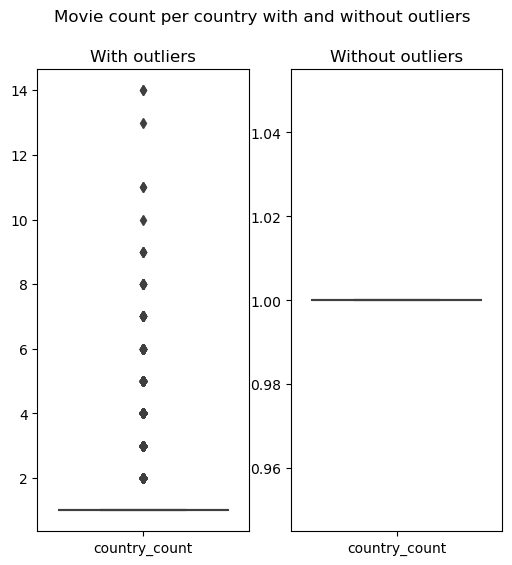

In [65]:
count_box_plot(country_per_movie_count_df,"Movie count per country with and without outliers")

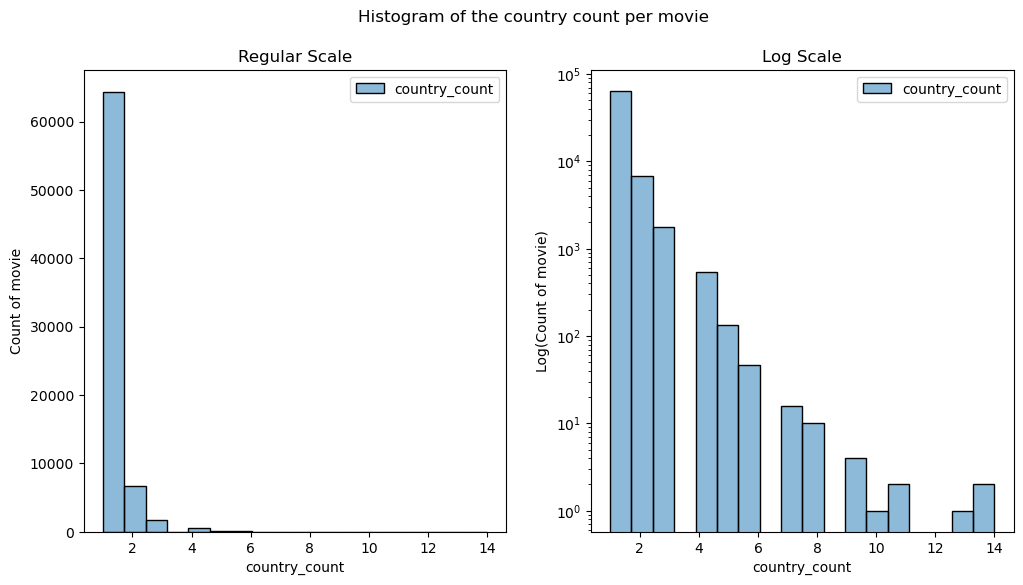

In [66]:
count_draw_histogram(country_per_movie_count_df,country_per_movie_log_count_df,
                           "Histogram of the country count per movie",log_ax="y")

### Top and bottom movies

In [67]:
top_name_movies = country_per_movie_count_df.head(10).reset_index()
top_name_movies["movie_name"] = top_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
top_name_movies = top_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("The 10 movies with the biggest number of countries are:\n")
print(top_name_movies.to_markdown())
bot_name_movies = country_per_movie_count_df.tail(10).reset_index()
bot_name_movies["movie_name"] = bot_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
bot_name_movies = bot_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("\nThe 10 movies with the lowest number of countries are:\n")
print(bot_name_movies.to_markdown())

The 10 movies with the biggest number of countries are:

| movie_name                                |   country_count |
|:------------------------------------------|----------------:|
| My Reincarnation                          |              14 |
| The Mahabharata                           |              14 |
| Dancer in the Dark                        |              13 |
| Burma VJ: Reporting from a Closed Country |              11 |
| Manderlay                                 |              11 |
| Dragon Hunters                            |              10 |
| Bananas!*                                 |               9 |
| The Best Intentions                       |               9 |
| Thieves By Law                            |               9 |
| Ulysses' Gaze                             |               9 |

The 10 movies with the lowest number of countries are:

| movie_name               |   country_count |
|:-------------------------|----------------:|
| The Great War         

## Genres
In this section we will study the data distribution of the genres in our dataset. Indeed, there are many genres that are widely represented such as drama or comedy, and others that are specific to only a few movies. 

### Descriptive statistics
From the following plots we can see that our data is heavy tailed, with a lot of genres having only a few movies. We will thus need to use robust statistics.

In [33]:
genre_count_df = is_of_type_df.groupby("genre_name").count().sort_values(
    "movie_id",key=lambda l: -l)
genre_count_df.columns = ["movie_count"]
genre_log_count_df = genre_count_df.apply(np.log)

In [34]:
genre_median_count = genre_count_df.median().item()
print(f"The median number of movies per genre is {genre_median_count}.")

The median number of movies per genre is 65.0.


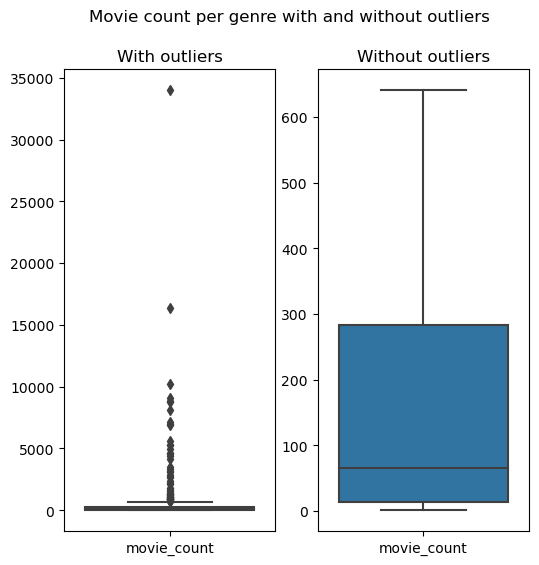

In [35]:
count_box_plot(genre_count_df,"Movie count per genre with and without outliers")

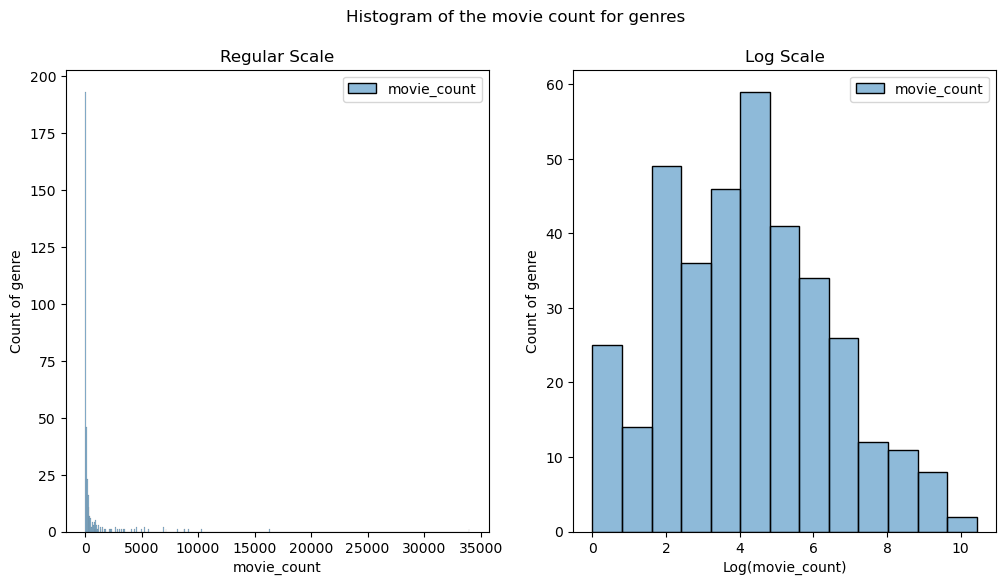

In [36]:
count_draw_histogram(genre_count_df,genre_log_count_df,
                           "Histogram of the movie count for genres")

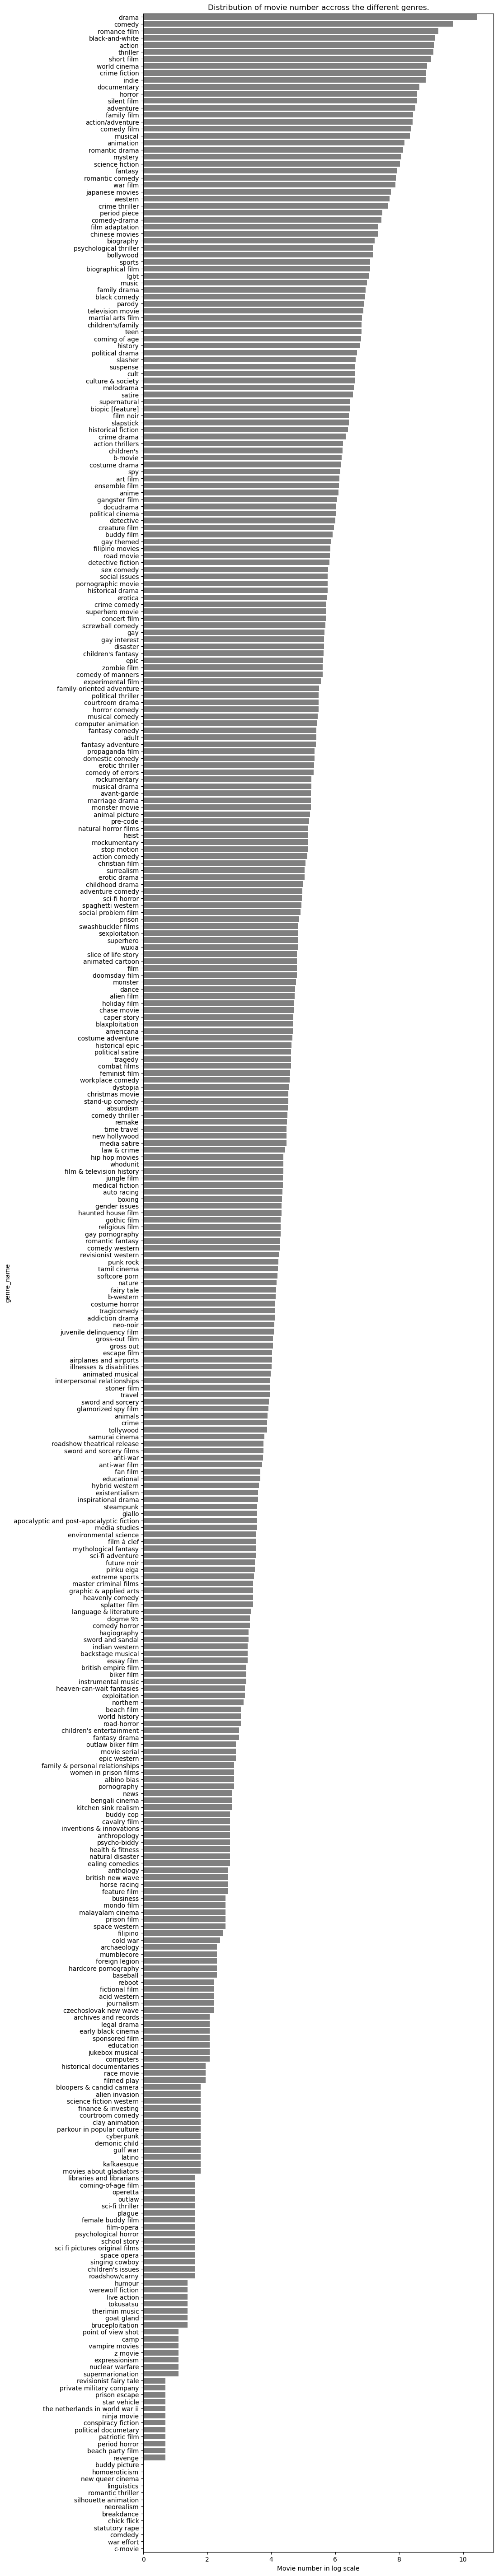

In [37]:
movie_count_bar_plot(genre_log_count_df,"Distribution of movie number accross the different genres.",
                    is_log=True)

### Top and bottom genres

In [38]:
print("The top 10 genres are:\n")
print(genre_count_df.head(10).to_markdown())
print("\nThe bottom 10 genres are:\n")
print(genre_count_df.tail(10).to_markdown())

The top 10 genres are:

| genre_name      |   movie_count |
|:----------------|--------------:|
| drama           |         34007 |
| comedy          |         16349 |
| romance film    |         10234 |
| black-and-white |          9094 |
| action          |          8798 |
| thriller        |          8744 |
| short film      |          8141 |
| world cinema    |          7155 |
| crime fiction   |          6948 |
| indie           |          6897 |

The bottom 10 genres are:

| genre_name           |   movie_count |
|:---------------------|--------------:|
| linguistics          |             1 |
| romantic thriller    |             1 |
| silhouette animation |             1 |
| neorealism           |             1 |
| breakdance           |             1 |
| chick flick          |             1 |
| statutory rape       |             1 |
| comdedy              |             1 |
| war effort           |             1 |
| c-movie              |             1 |


## Movie to Genre Relation

We now focus on the links between movies and genres. More especially, we are interested in the distribution of genres per movie.

In [39]:
genre_per_movie_count_df = is_of_type_df.groupby("movie_id").count().sort_values("genre_name",key=lambda l: -l)
genre_per_movie_count_df.columns = ["genre_count"]
genre_per_movie_log_count_df = genre_per_movie_count_df.apply(np.log)

In [43]:
genre_per_movie_count_median = genre_per_movie_count_df.median().item()
print(f"The median number of genres per movie is {genre_per_movie_count_median}.")

The median number of genres per movie is 3.0.


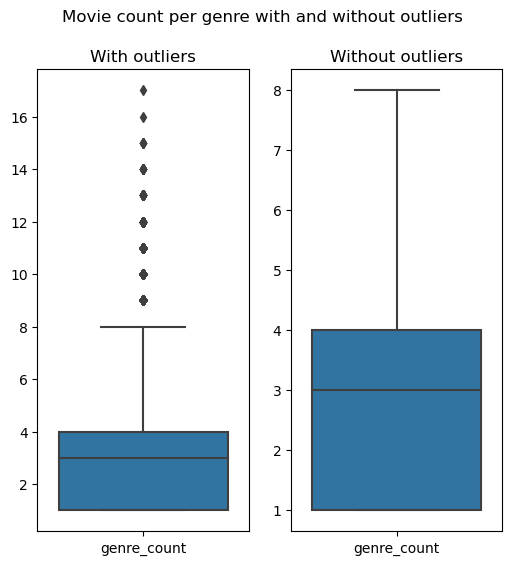

In [44]:
count_box_plot(genre_per_movie_count_df,"Movie count per genre with and without outliers")

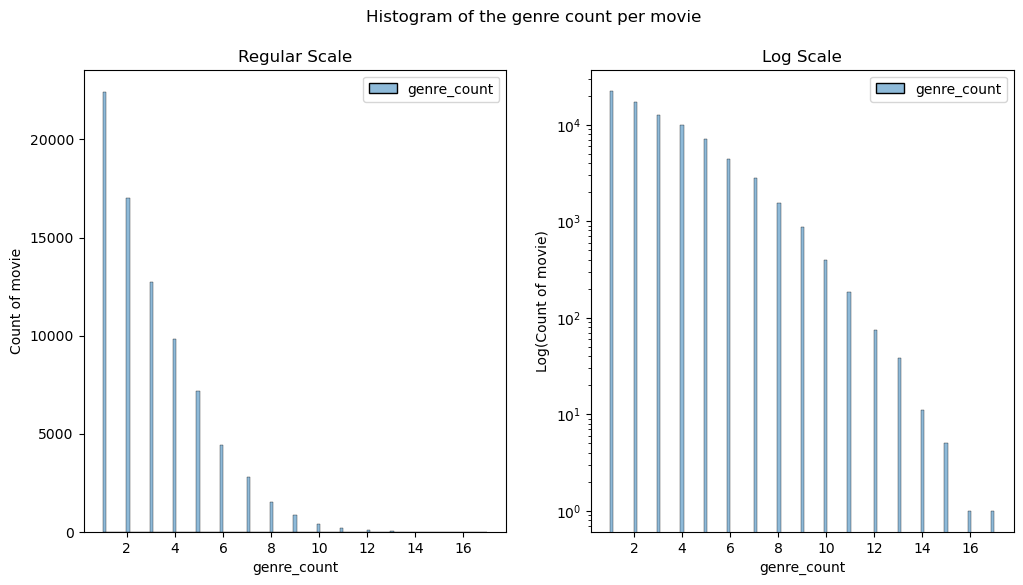

In [45]:
count_draw_histogram(genre_per_movie_count_df,genre_per_movie_log_count_df,
                           "Histogram of the genre count per movie", log_ax="y")

### Top and bottom movies

In [46]:
top_name_movies = genre_per_movie_count_df.head(10).reset_index()
top_name_movies["movie_name"] = top_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
top_name_movies = top_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("The 10 movies with the biggest number of genres are:\n")
print(top_name_movies.to_markdown())
bot_name_movies = genre_per_movie_count_df.tail(10).reset_index()
bot_name_movies["movie_name"] = bot_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
bot_name_movies = bot_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("\nThe 10 movies with the lowest number of genres are:\n")
print(bot_name_movies.to_markdown())

The 10 movies with the biggest number of genres are:

| movie_name                                       |   genre_count |
|:-------------------------------------------------|--------------:|
| Young Sherlock Holmes                            |            17 |
| Naked Lunch                                      |            16 |
| Van Helsing                                      |            15 |
| Caligula                                         |            15 |
| Donnie Darko                                     |            15 |
| The Adventures of Priscilla, Queen of the Desert |            15 |
| The Raspberry Reich                              |            15 |
| The Doom Generation                              |            14 |
| The Sum of Us                                    |            14 |
| Brotherhood of the Wolf                          |            14 |

The 10 movies with the lowest number of genres are:

| movie_name                     |   genre_count |
|:-----------

## Languages
In this section we will study the data distribution of the languages in our dataset. Indeed, there some languages that are spoken in many different movies such as english or indian, and others that are specific to only a few movies. 

### Descriptive statistics
From the following plots we can see that our data is heavy tailed, with a lot of genres having only a few movies. We will thus need to use robust statistics.

In [47]:
language_count_df = spoken_languages_df.groupby("language_name").count().sort_values(
    "movie_id",key=lambda l: -l)
language_count_df.columns = ["movie_count"]
language_log_count_df = language_count_df.apply(np.log)

In [48]:
language_median_count = language_count_df.median().item()
print(f"The median number of movies per language is {language_median_count}.")

The median number of movies per language is 10.0.


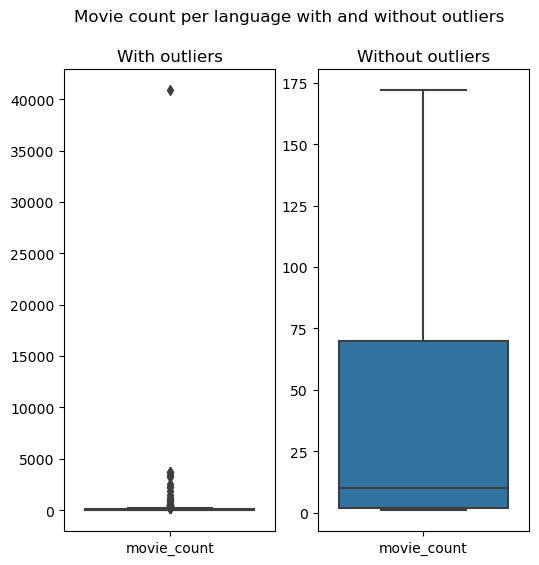

In [50]:
count_box_plot(language_count_df,"Movie count per language with and without outliers")

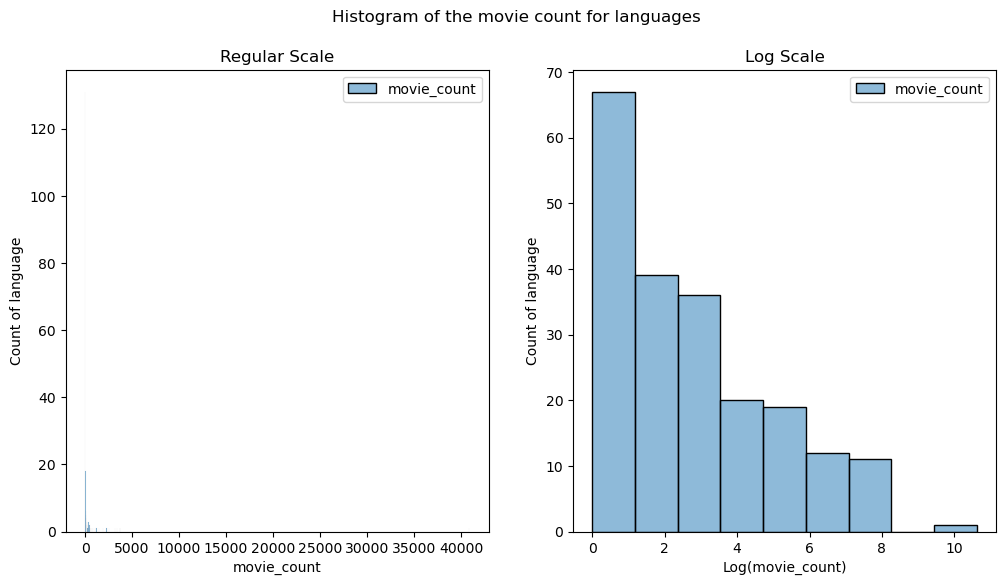

In [51]:
count_draw_histogram(language_count_df,language_log_count_df,
                           "Histogram of the movie count for languages")

C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66622 (\N{DESERET SMALL LETTER JEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66610 (\N{DESERET SMALL LETTER SHORT O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66633 (\N{DESERET SMALL LETTER ER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66635 (\N{DESERET SMALL LETTER EM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jerem\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 66636 (\N{DESERET SMALL LETTER EN}) missing from current fo

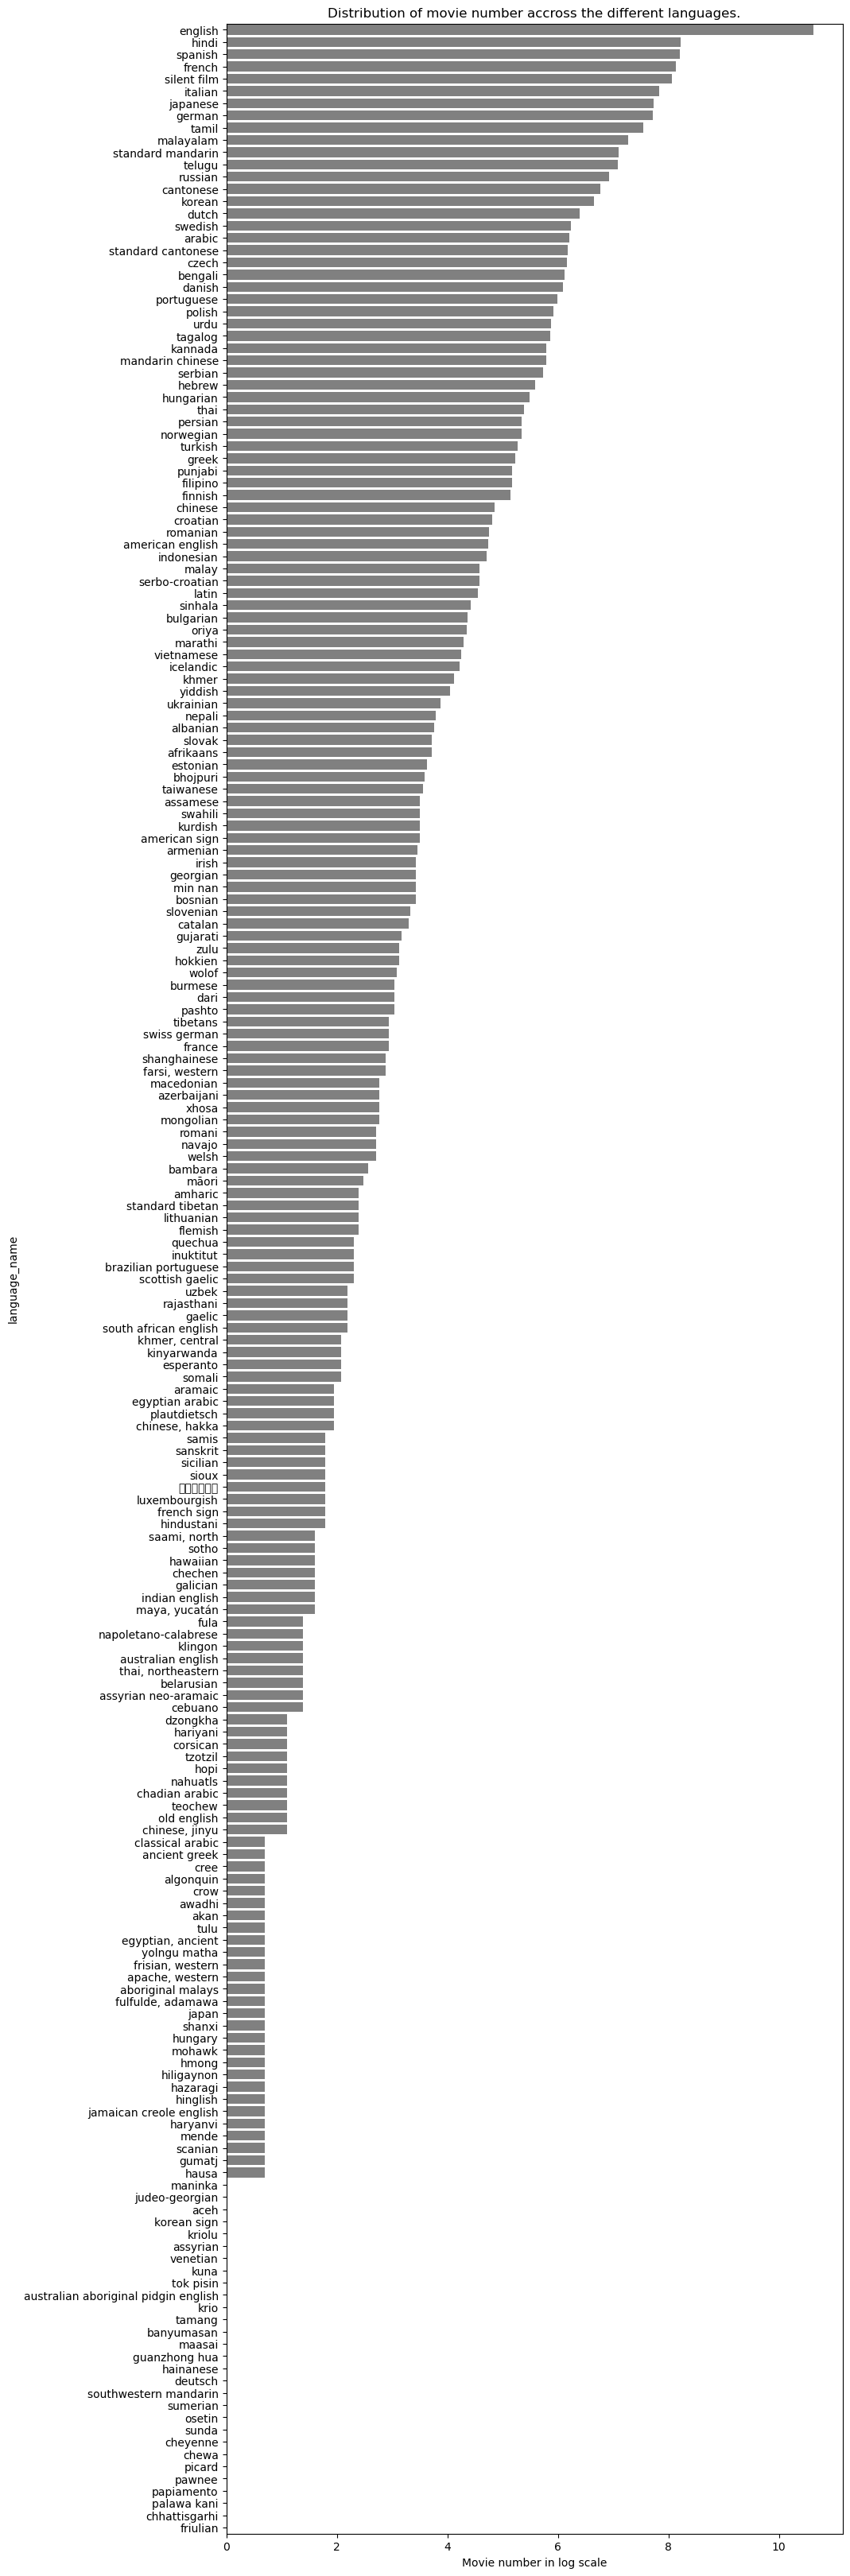

In [52]:
movie_count_bar_plot(language_log_count_df,"Distribution of movie number accross the different languages.",
                    is_log=True)

### Top and bottom languages

In [53]:
print("The 10 languages the most used are:\n")
print(language_count_df.head(10).to_markdown())
print("\nThe 10 languages the less used are:\n")
print(language_count_df.tail(10).to_markdown())

The 10 languages the most used are:

| language_name   |   movie_count |
|:----------------|--------------:|
| english         |         40891 |
| hindi           |          3744 |
| spanish         |          3673 |
| french          |          3422 |
| silent film     |          3183 |
| italian         |          2532 |
| japanese        |          2295 |
| german          |          2262 |
| tamil           |          1896 |
| malayalam       |          1448 |

The 10 languages the less used are:

| language_name   |   movie_count |
|:----------------|--------------:|
| osetin          |             1 |
| sunda           |             1 |
| cheyenne        |             1 |
| chewa           |             1 |
| picard          |             1 |
| pawnee          |             1 |
| papiamento      |             1 |
| palawa kani     |             1 |
| chhattisgarhi   |             1 |
| friulian        |             1 |


## Movie to Language Relation
We now focus on the links between movies and languages. More especially, we are interested in the distribution of languages per movie.

In [138]:
language_per_movie_count_df = spoken_languages_df.groupby("movie_id").count().sort_values(
    "language_name",key=lambda l: -l)
language_per_movie_count_df.columns = ["language_count"]
language_per_movie_log_count_df = language_per_movie_count_df.apply(np.log)

In [139]:
language_per_movie_count_median = language_per_movie_count_df.median().item()
print(f"The median number of genres per movie is {language_per_movie_count_median}.")

The median number of genres per movie is 1.0.


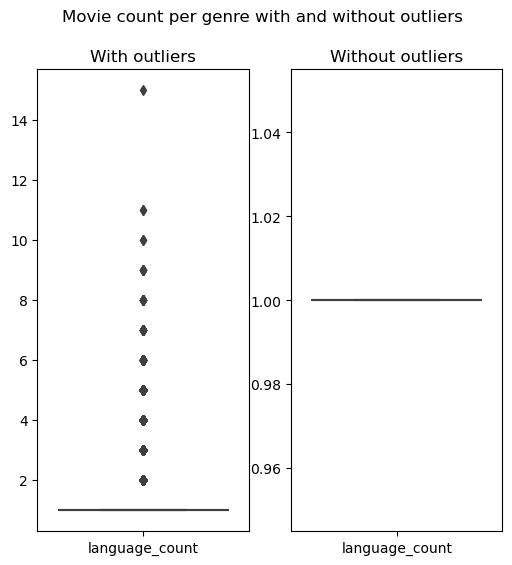

In [140]:
count_box_plot(language_per_movie_count_df,"Movie count per genre with and without outliers")

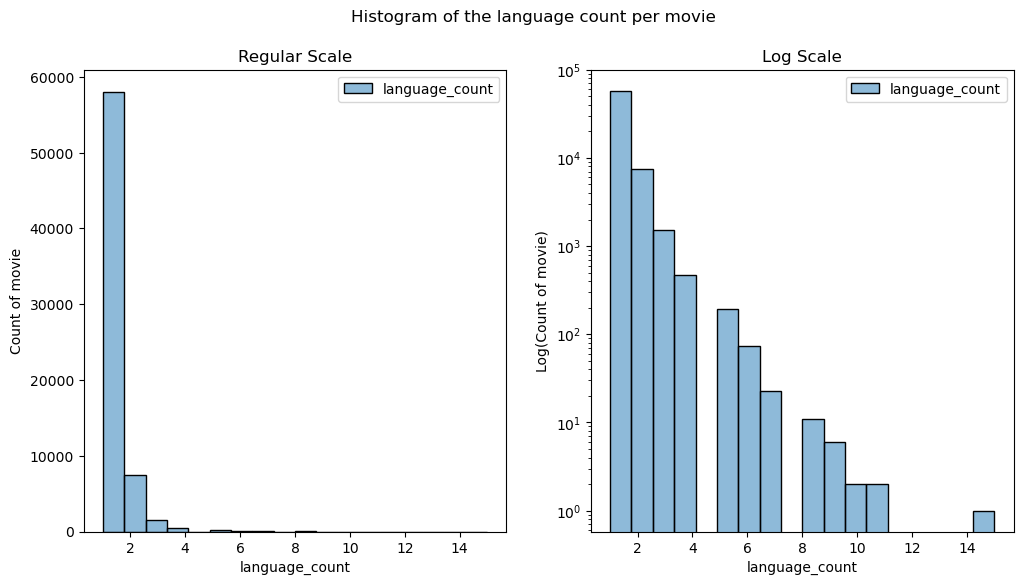

In [141]:
count_draw_histogram(language_per_movie_count_df,language_per_movie_log_count_df,
                           "Histogram of the language count per movie", log_ax="y")

### Top and bottom movies

In [59]:
top_name_movies = language_per_movie_count_df.head(10).reset_index()
top_name_movies["movie_name"] = top_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
top_name_movies = top_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("The 10 movies with the biggest number of languages are:\n")
print(top_name_movies.to_markdown())
bot_name_movies = language_per_movie_count_df.tail(10).reset_index()
bot_name_movies["movie_name"] = bot_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
bot_name_movies = bot_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("\nThe 10 movies with the lowest number of languages are:\n")
print(bot_name_movies.to_markdown())

The 10 movies with the biggest number of languages are:

| movie_name                |   genre_count |
|:--------------------------|--------------:|
| Jai Jagannatha            |            15 |
| Youth Without Youth       |            11 |
| Pina                      |            11 |
| To Each His Own Cinema    |            10 |
| The Adventures of Picasso |            10 |
| Bal-Can-Can               |             9 |
| Hostel                    |             9 |
| The Last Communist        |             9 |
| Ten Minutes Older         |             9 |
| 2012                      |             9 |

The 10 movies with the lowest number of languages are:

| movie_name                  |   genre_count |
|:----------------------------|--------------:|
| Clancy of the Mounted       |             1 |
| Dar la cara                 |             1 |
| Delito                      |             1 |
| Dr. Cándido Pérez, señoras  |             1 |
| La Chacota                  |             1 

## Movies

### Missing Values

We already handled a significant part of movies with missing release date but there remain some movies with missing release date and other information. Our primary focus was release date but we need to think of potential way to circumvent this absence of information. Note that for further analysis we may solely focus on the movies for which we have an IMDB id. Thus the amount of missing variable could be reduce in this subset of the dataset.

In [78]:
movies_with_missing_name = movie_df["name"].isna()
movies_with_missing_release_date = movie_df["release_date"].isna()
movies_with_missing_revenue = movie_df["revenue"].isna()
movies_with_missing_runtime = movie_df["runtime"].isna()
movies_with_missing_freebase_id = movie_df["freebase_id"].isna()
movies_with_missing_plot = movie_df["plot"].isna()

In [79]:
print(f"Our dataset contains {len(movie_df)} entries but is not complete, we have some entries with missing values:\n")
print(f"\t-Number of movies with missing name: {movies_with_missing_name.sum()}")
print(f"\t-Number of movies with missing freebase_id: {movies_with_missing_freebase_id.sum()}")
print(f"\t-Number of movies with missing release date: {movies_with_missing_release_date.sum()}")
print(f"\t-Number of movies with missing revenue: {movies_with_missing_revenue.sum()}")
print(f"\t-Number of movies with missing runtime: {movies_with_missing_runtime.sum()}")
print(f"\t-Number of movies with missing plot: {movies_with_missing_plot.sum()}")

Our dataset contains 81741 entries but is not complete, we have some entries with missing values:

	-Number of movies with missing name: 0
	-Number of movies with missing freebase_id: 0
	-Number of movies with missing release date: 2416
	-Number of movies with missing revenue: 73340
	-Number of movies with missing runtime: 20450
	-Number of movies with missing plot: 39537


### Release Year
This will be one of the cornerstone aspect of our analysis. We focus on the year and not the exact release date. This is because many movies have the January 1st of a given year as release date, which is a default value when we only know the release year.

In [177]:
release_year_df = movie_df["release_date"].apply(lambda d: d.year).reset_index()
release_year_df.columns = ["movie_id","release-year_date"]
release_year_df = release_year_df.set_index("movie_id")
release_year_count_df = release_year_df.reset_index().groupby("release-year_date").count().sort_values(
    "movie_id",key=lambda l: -l)
release_year_count_df.columns = ["movie_count"]
release_year_log_count_df = release_year_count_df.apply(np.log)

In [178]:
release_year_count_median = release_year_count_df.median().item()
release_year_median = release_year_df.median()
print(f"The median release year for our movies is {release_year_median}.")
print(f"The median number of movies per release year is {release_year_count_median}.")

The median release year for our movies is release-year_date    1985.0
dtype: float64.
The median number of movies per release year is 532.0.


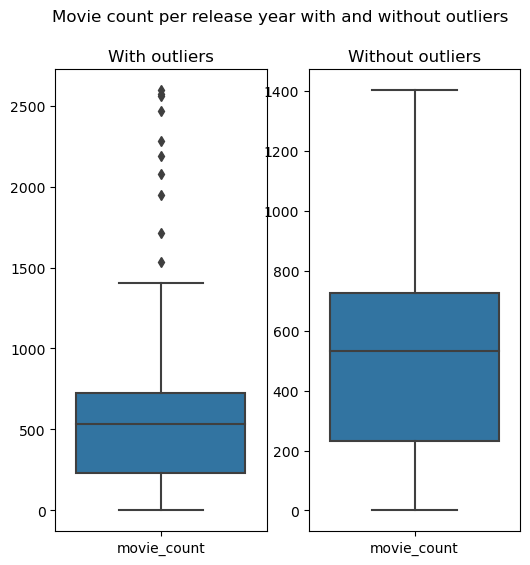

In [179]:
count_box_plot(release_year_count_df,"Movie count per release year with and without outliers")

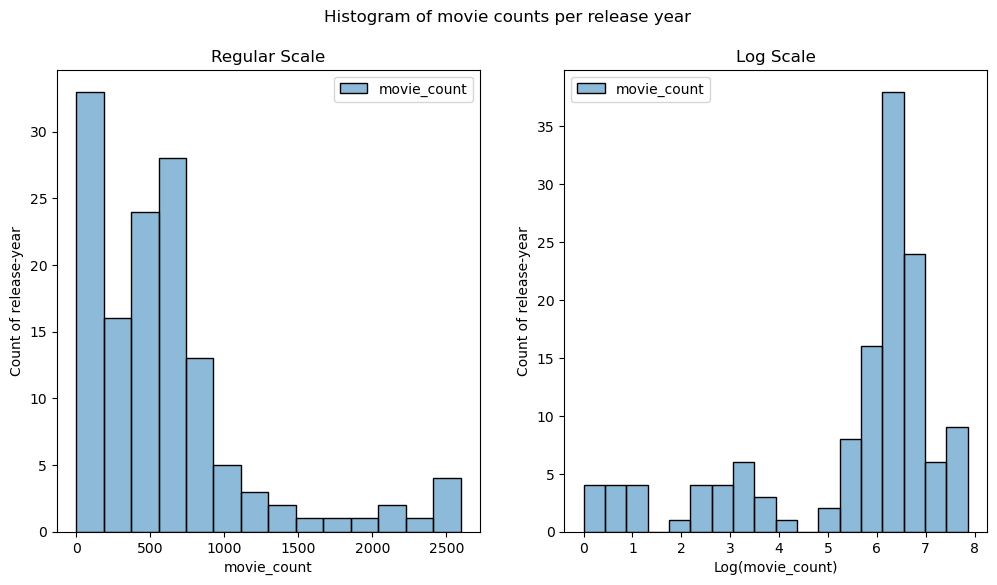

In [180]:
count_draw_histogram(release_year_count_df,release_year_log_count_df,"Histogram of movie counts per release year")

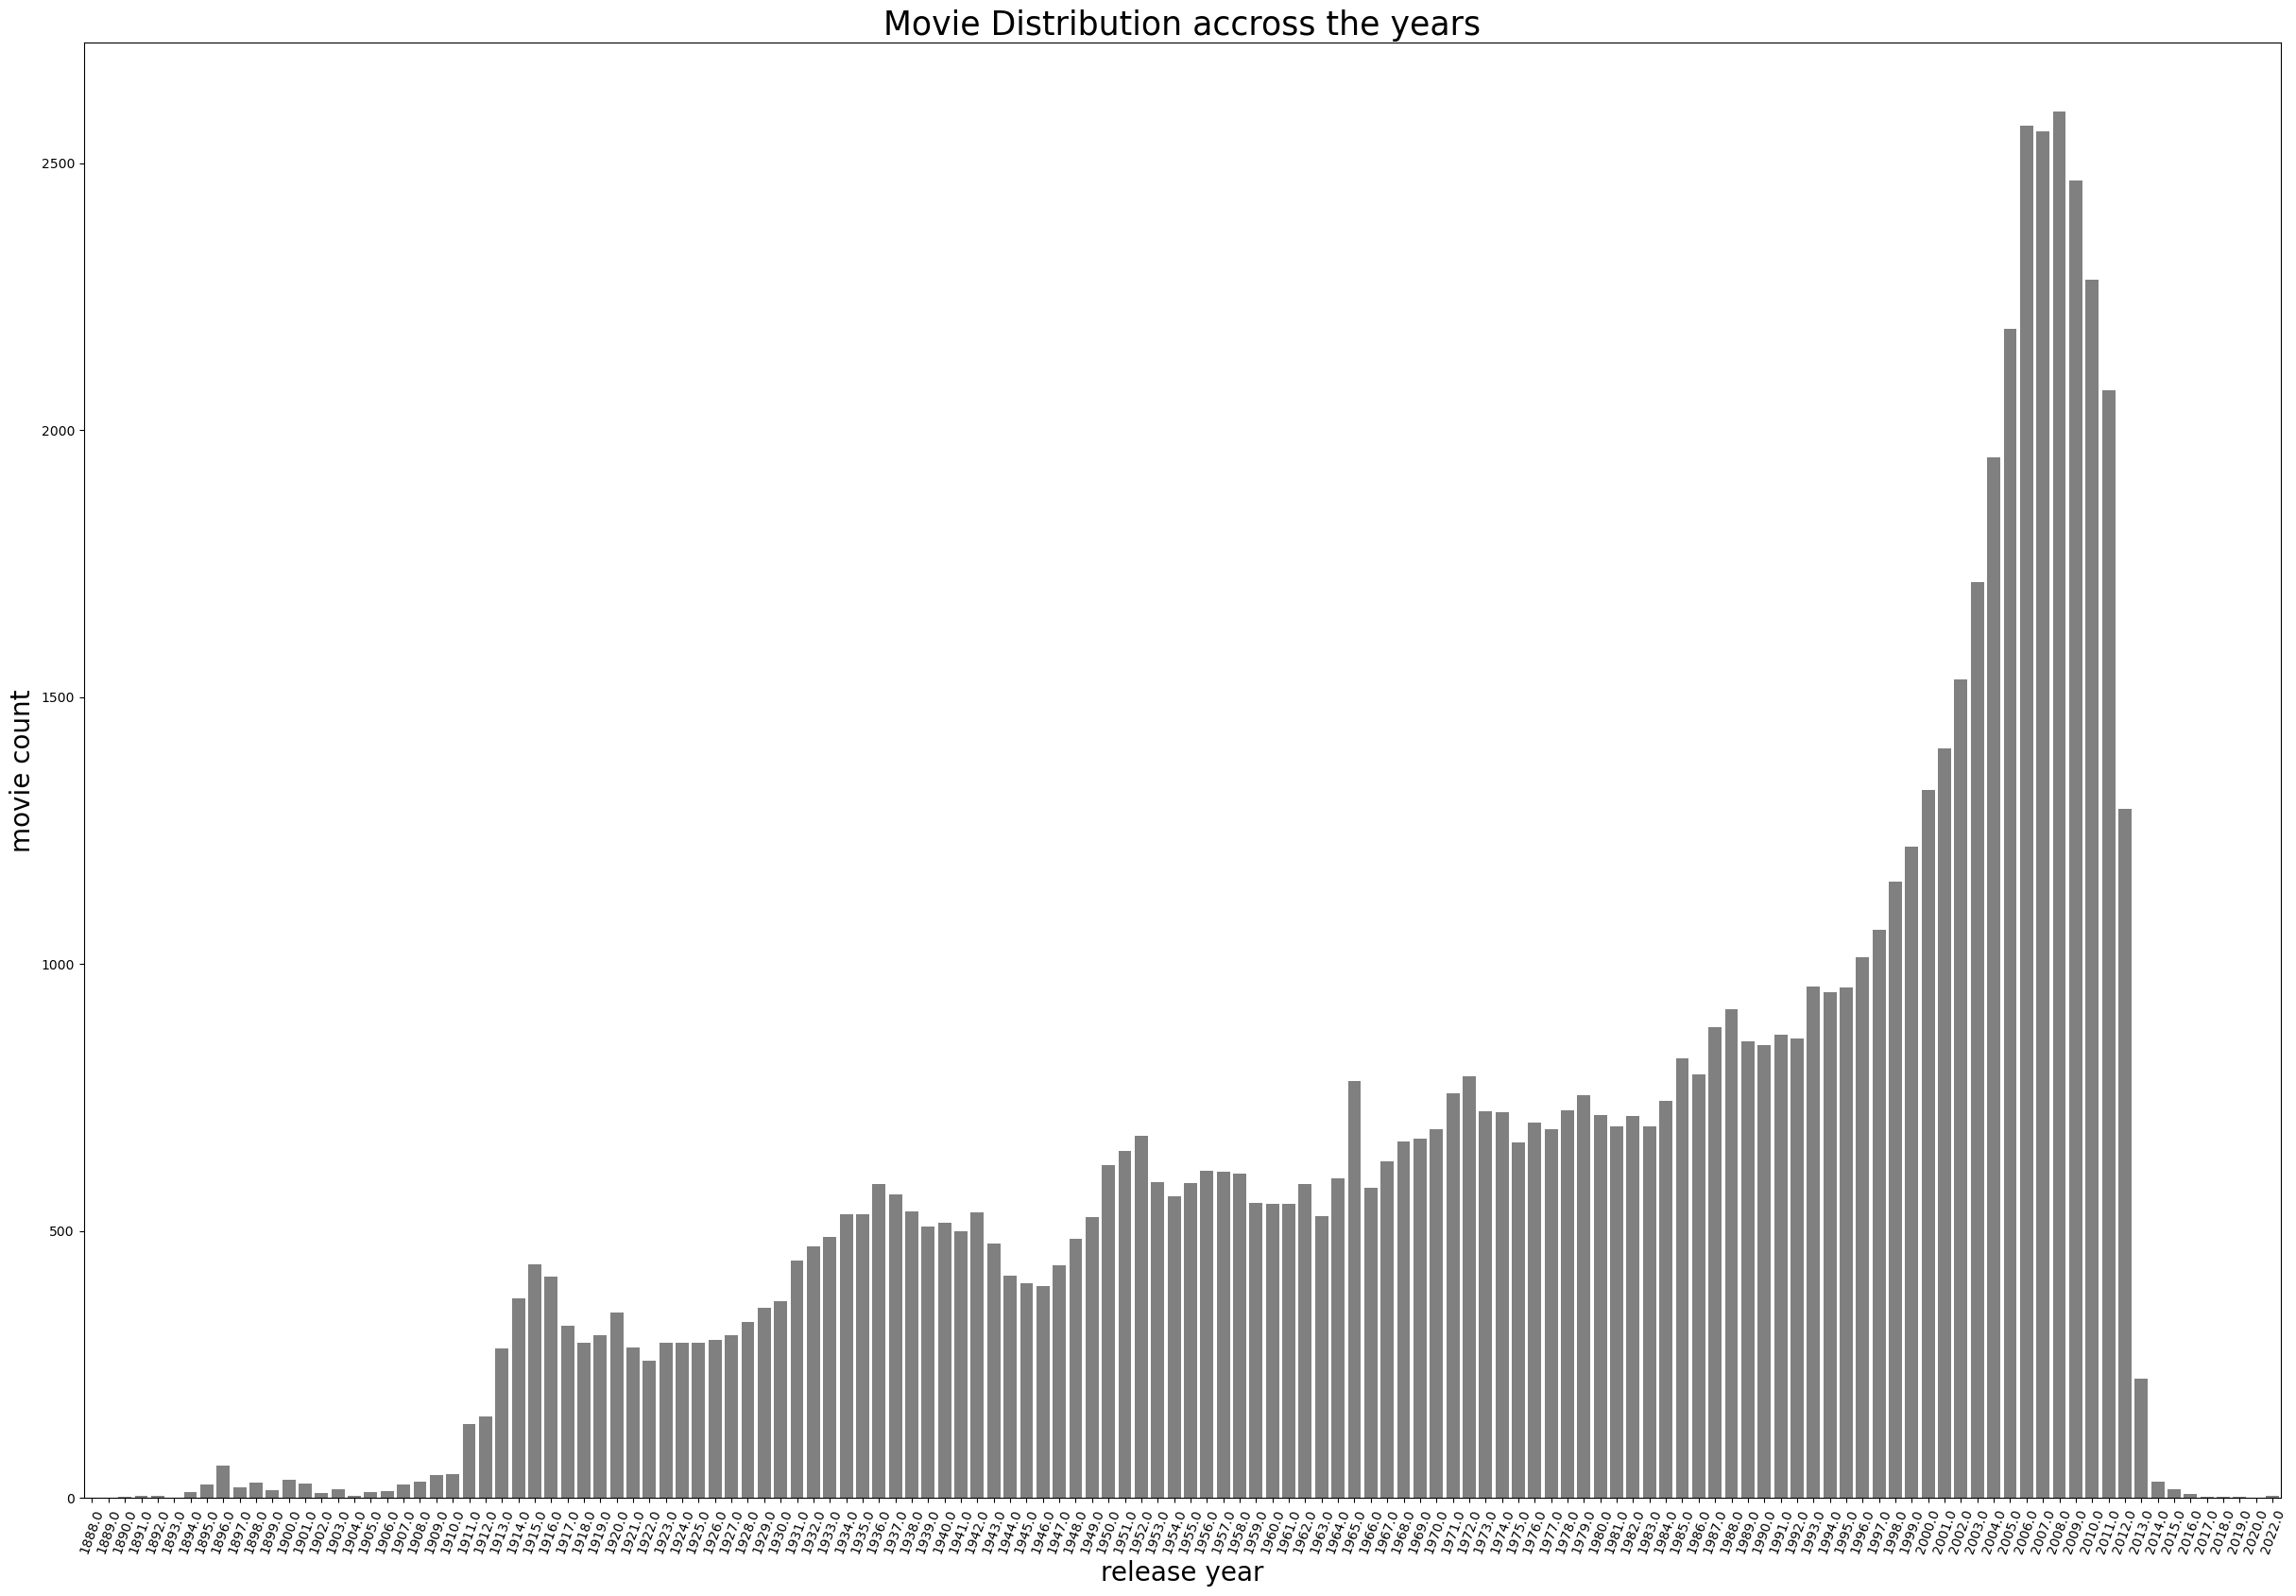

In [188]:
release_year_count_df = release_year_df.reset_index().groupby("release-year_date").count()
release_year_count_df.columns = ["movie_count"]
fig, ax = plt.subplots(1,figsize=(30,20))
ax.set_title("Movie Distribution accross the years",fontsize=25)
sns.barplot(x=release_year_count_df.index,y=release_year_count_df.movie_count,
                orient="v",ax=ax, color="grey")
ax.set_xlabel("release year",fontsize=20)
ax.set_ylabel("movie count",fontsize=20)
plt.xticks(rotation=70);

### Runtime
From the plots below we can clearly see that we have some outliers that are either some very special movies such as "Modern Times Forever" which is a 240 hours long documentary or we even have shows with several episodes. If we are interested in the future by this feature we will have to filter out the movies with aberrant runtimes.

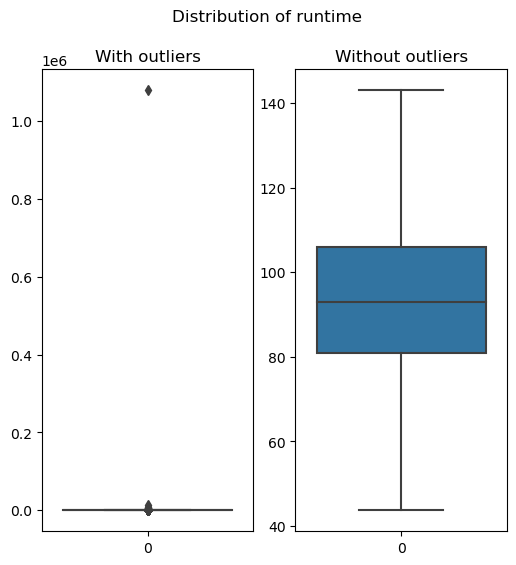

In [222]:
runtime_df = movie_df[~movie_df["runtime"].isna()]["runtime"]
count_box_plot(runtime_df.values,"Distribution of runtime")

In [237]:
get_top_and_bot_of_series(runtime_df, movie_df)

The 10 movies with the highest runtime are:

| movie_name                                      |         runtime |
|:------------------------------------------------|----------------:|
| Zero Tolerance                                  |     1.07928e+06 |
| Modern Times Forever                            | 14400           |
| Cinématon                                       |  9360           |
| Matrjoschka                                     |  5700           |
| The Cure for Insomnia                           |  5220           |
| Paradise in Harlem                              |  5100           |
| Kai Koduttha Dheivam                            |  4875.27        |
| The Longest Most Meaningless Movie in the World |  2880           |
| Gigantor                                        |  2425           |
| Dil Ne Phir Yaad Kiya                           |  1966           |

The 10 movies with the lowest runtime are:

| movie_name                      |   runtime |
|:--------------------

### Revenue

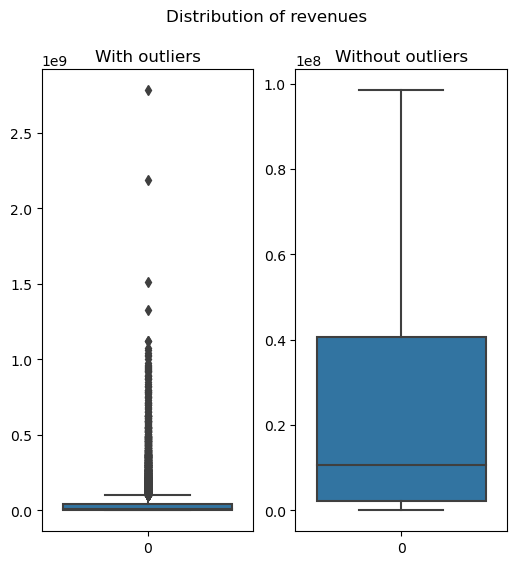

In [235]:
revenue_df = movie_df[~movie_df["revenue"].isna()]["revenue"]
count_box_plot(revenue_df.values,"Distribution of revenues")

In [236]:
get_top_and_bot_of_series(revenue_df, movie_df)

The 10 movies with the highest revenue are:

| movie_name                                    |     revenue |
|:----------------------------------------------|------------:|
| Avatar                                        | 2.78228e+09 |
| Titanic                                       | 2.18537e+09 |
| The Avengers                                  | 1.51176e+09 |
| Harry Potter and the Deathly Hallows – Part 2 | 1.32811e+09 |
| Transformers: Dark of the Moon                | 1.12375e+09 |
| The Lord of the Rings: The Return of the King | 1.11993e+09 |
| The Dark Knight Rises                         | 1.07801e+09 |
| Toy Story 3                                   | 1.06317e+09 |
| Pirates of the Caribbean: On Stranger Tides   | 1.04387e+09 |
| Star Wars Episode I: The Phantom Menace       | 1.02704e+09 |

The 10 movies with the lowest revenue are:

| movie_name                               |   revenue |
|:-----------------------------------------|----------:|
| Iron Warrior              